# Chapter 3: Word2vec - Learning Word Embeddings

In [1]:
%matplotlib inline
from __future__ import division, print_function, unicode_literals
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
import pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil
import csv
from tensorflow_graph_in_jupyter import show_graph

C:\Peter\Anaconda36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# In[2]:

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp_tens"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


## Dataset
This code downloads a [dataset](http://www.evanjones.ca/software/wikipedia2text.html) consisting of several Wikipedia articles totaling up to roughly 61 megabytes. Additionally the code makes sure the file has the correct size after downloading it.

In [3]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    print('Downloading file...')
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('../wikipedia2text-extracted.txt.bz2', 18377035)


Found and verified ../wikipedia2text-extracted.txt.bz2


## Read Data without Preprocessing 
Reads data as it is to a string and tokenize it using spaces and returns a list of words

In [4]:
def read_data(filename):
    '''Extract the first file enclosed in a zip file as a
       list of words'''

    with bz2.BZ2File(filename) as f:
        data = []
        file_string = f.read().decode('utf-8')
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
    return data
words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start):', words[:10])
print('Example words (end):', words[-10:])


Data size 11633206
Example words (start): ['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end): ['useless', 'for', 'cultivation', '.', 'and', 'people', 'have', 'sex', 'there', '.']


## Read Data with Preprocessing with NLTK
Reads data as it is to a string, convert to lower-case and tokenize it using the nltk library. This code reads data in 1MB portions as processing the full text at once slows down the task and returns a list of words. You will have to download the necessary tokenizer.

In [5]:
def read_data(filename):
  """
  Extract the first file enclosed in a zip file as a list of 
  words and pre-processes it using the nltk python library.
  """
  with bz2.BZ2File(filename) as f:
      data = []
      file_size = os.stat(filename).st_size
      print('file_size',file_size)
      chunk_size = 1024 * 1024 # reading 1 MB at a time as the
                               # dataset is moderately large
      print('Reading data...')
      for i in range(ceil(file_size//chunk_size)+1):
          bytes_to_read = min(chunk_size, file_size-(i*chunk_size))
          file_string = f.read(bytes_to_read).decode('utf-8')
          #print('string_token:', file_string)
          file_string = file_string.lower()
          # tokenizes a string to word residing in a list
          file_string = nltk.word_tokenize(file_string)
          #print('\nstring_token:', file_string)
          data.extend(file_string)
  return data

words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start):', words[:10])
print('Example words (end):', words[-10:])

file_size 18377035
Reading data...
Data size 3360745
Example words (start): ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end): ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


## Building the Dictionaries
由要處理的文章來建立Dictionary (不是使用已有的資料庫當字典)  
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words for too rare use.

In [6]:
# we restrict our vocabulary size to 50000
vocabulary_size = 50000

'''
傳回：上述說明，但注意底下count的['UNK', 68909]是以list存在，其他為tuple存在 
'''
def build_dataset(words):
    count = [['UNK', -1]]
    # Gets only the vocabulary_size most common words as the vocabulary
    # All the other words will be replaced with UNK token
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    # Create an ID for each word by giving the current length of the dictionary
    # And adding that item to the dictionary
    '''以count出現的次序處理，即出現次數高低次序，例，最高次數'UNK'，此時
       len(dictionary)=0，dictionary['UNK']=0 => 
       len(dictionary)=1，dictionary['the']=1 => 循環... =>   
       dictionary：{UNK:0, the:1, ,:2, .:3, of:4, ...}
       此dictionary value就是index，再經text_digt處理成原文字的index'''
       
    for word, _ in count:
        dictionary[word] = len(dictionary)  
        
    text_digt = list()
    unk_count = 0
    # Traverse through all the text we have and produce a list
    # where each element corresponds to the ID of the word found at that index
    for word in words:
        # If word of the dictionary uses the word ID,
        # else use the ID of the special token "UNK"
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0   # dictionary['UNK']
            unk_count += 1
        text_digt.append(index)
            
    # updata the count variable with the number of UNK occurences
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # Make sure the dictionary is of size of the vocabulary
    assert len(dictionary) == vocabulary_size
    
    return text_digt, count, dictionary, reverse_dictionary

text_digt, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK): ', count[:10])
print('words:', words[:10])
print('Sample text_digitize:', text_digt[:10])
del words

Most common words (+UNK):  [['UNK', 68909], ('the', 226892), (',', 184013), ('.', 120944), ('of', 116323), ('and', 88639), ('in', 77803), ('to', 65637), ('a', 58911), ('is', 30858)]
words: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Sample text_digitize: [1721, 9, 8, 16476, 223, 4, 5165, 4456, 26, 11593]


## Generating Batches of Data for Skip-Gram
Skip-Gram Algorithm（中心詞(batch)預測背景詞(label)）  

Generates a batch or target words (`batch`) and a batch of corresponding context words (`labels`). It reads `2*window_size+1` words at a time (called a `span`) and create `2*window_size` datapoints in a single span. The function continue in this manner until `batch_size` datapoints are created. Everytime we reach the end of the word sequence, we start from beginning. 

In [7]:
'''
目的：處理以中心詞前後 window_size範圍的span框架
傳入：text_digt, batch_size， window_size
傳回： batch為中心詞的list；
      label為框架內的背景詞list

例：text_digt: ['propaganda','is','a','concerted', 'set','of','messages','aimed']
   window_size=1 時回傳：
   batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
   labels: ['propaganda','a','is','concerted','a','set','concerted','of']
   表span框架為 (中心詞，前1背景詞):('is','propaganda')及
                (中心詞，後1背景詞):('is','a')...
   所以batch有2個'is'
   
   window_size=2 時回傳：
    batch: ['a', 'a', 'a', 'a','concerted','concerted','concerted','concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']
   表span框架為 (中心詞，前2背景詞): ('a','propaganda'), ('a','is')及
                (中心詞，後2背景詞): ('a','concerted'), ('a','set')...
   所以batch有4個'a'   
'''
data_index = 0
def generate_batch_skip_gram(text_digt, batch_size, window_size):
    # dsata_index is updated by 1 everytime we read a data point
    global data_index
    
    # two numpy arrays to hold target words (batch) 
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels= np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span defines the total window size, where text_digt
    #  is we consider at an instance looks as follows.
    # [skip_window, target, skip_window]
    span = 2 * window_size +1
    
    # The buffer holds the data contained within the span
    '''
    collections.deque用來解串列
    buffer框架大小由span限制'''
    buffer = collections.deque(maxlen = span)    
    
    # Fill the buffer and update the data_index
    '''
    buffer用來解text_digt串列
    data_index 用來移動 text_digt指涉值放入buffer框架    
    '''
    for _ in range(span):
        buffer.append(text_digt[data_index])
        data_index = (data_index + 1) % len(text_digt)
        
    # This is the number of context words we sample single target word
    num_samples = 2 * window_size
    
    # We break the batch reading into two loops
    # The inner loop fills in the batch and labels withnum_samples
    # text_digt points using text_digt contained withing the span
    # The output loop repeat this for batch_size//nuum_samples
    # times to produce a full batch
    for i in range(batch_size // num_samples):
        #print('bufferi:',buffer)
        k = 0
        # avoid the target word itself as a prediction
        # fill in batch and label numpy arrays
        for j in list(range(window_size))+\
        list(range(window_size+1, 2*window_size+1)):
            # j是span範圍扣掉中心詞的index的值
            batch[i*num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1
            #print('window_size:',window_size)
            #print('i:',i,'j:',j,'k:',k)
            #print('buffer[window_size]:',buffer[window_size])
            #print('buffer[j]:',buffer[j])
            #print('batch', batch)
            #print('labels', labels)            
            
        # Everytime we read num_sample text_digt points, 
        # we having created the maximum number of datapoints 
        # possible withing a single span, so we need to move
        # the span by 1 to create a fresh new_span
        # data_index 用來移動 data指涉值放入buffer框架
        buffer.append(text_digt[data_index]) 
        data_index = (data_index + 1) % len(text_digt)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in text_digt[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(text_digt, batch_size=8,
                                             window_size = window_size)
    print(' with  window_size = %d:' %window_size)
    print(' batch:', [reverse_dictionary[bi] for bi in batch])
    print(' labels:',[reverse_dictionary[li] for li in labels.reshape(8)])            
 

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']
 with  window_size = 1:
 batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
 labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']
 with  window_size = 2:
 batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
 labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## Skip-Gram Algorithm

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [8]:
import random
batch_size = 128 # Data Points in a single batch.
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4  # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors.
valid_size = 16 # Random set of words to evaluate similarity.
# We sample valid datapoints randomly from a large  
# window without always being deterministic.
valid_window = 50

# 第一行 valid example, 選擇某些最常出現的字 
# 第二行 valid exampleas 再加入同量較少出現的字
# random.sample(population樣本, k取樣數) 
# 回傳長度為 k 且元素唯一的 list。此為非重置抽樣 (sampling without replacement)
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(\
            range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.


### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [9]:
reset_graph()
''''此處train_dataset和train_labels是文本數字化的ID，
也就是上面generate_batch_skip_gram()傳回的batch, labels'''
# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label dasta (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder as we have
# already defined the IDs of the words selected as validation data.
'''valid_dataset 隨機選擇用來驗證的 ID dataset被tf.constant固定
   即，每次驗證的valid_examples是同一組，除非重執行valid_examples'''
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)


### Defining Model Parameters and Other Variables
We now define several TensorFlow variables such as an embedding layer (`embeddings`) and neural network parameters (`softmax_weights` and `softmax_biases`)

In [10]:
# Variables
'''Embeddding layer矩陣作用給所有字典的每個字一個 vector，
   其矩陣大小 [vocabulary_size,embedding_size]'''

embeddings = tf.Variable(tf.random_uniform([vocabulary_size,\
                         embedding_size], -1.0, 1.0))
    
# Softmax Weights and Biases
softmax_weights = tf.Variable(\
        tf.truncated_normal([vocabulary_size,embedding_size],\
        stddev = 0.5/math.sqrt(embedding_size)))
# tf.truncated_normal(shape, mean, stddev) 產生常態分布
softmax_biases = tf.Variable(tf.random_uniform(\
                   [vocabulary_size], 0.0, 0.01)) #產生均值分布


### Defining the Model Computations
We first defing a lookup function to fetch the corresponding embedding vectors for a set of given inputs. With that, we define negative sampling loss function tf.nn.sampled_softmax_loss which takes in the embedding vectors and previously defined neural network parameters.

In [11]:
# Model
'''
 Look up embedding vector from a batch of inputs id (text_digt).
 embedding_lookup(tensor, id):查找一個張量裡面索引(id)對應的列或行元素'''

embed = tf.nn.embedding_lookup(embeddings, train_dataset)

# Compute the softmax loss, using a sample of the negative labels each time.
# num_sampled指定負採樣數
loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(\
       weights=softmax_weights, biases=softmax_biases,\
       inputs=embed,labels=train_labels,\
       num_sampled=num_sampled, num_classes=vocabulary_size))


### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [12]:
 '''
Compute the similaruty between minibatch examples and all embeddings.
We use the cosine distance:
''' 
''' 
  Embedding Vector都是學習過的值，所以相似性都是 valid_dataset
  對所有字學習完的 Embedding Vector的cosine distance比較
  
  Embedding Vector 正規化（歸一化，normalization）
  reduce_sum(tensors, axis, keepdims)的reduce有降維作用
  因此keepdims=True則保持維度不降維'''
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings/norm
'''embedding_lookup(tensor, id)在tensor中查找id對應的列或行元素
其中valid_dataset 隨機選擇用來驗證的 ID dataset
找到的正規化的embedding vector(已學習改變的vector)用來計算相似性similarity
similarity = cosine distance= A‧B/|A||B| 因經正規化,所以|A|=|B|=1，
=> similarity = A‧B (矩陣內積)（0度最相似cos(0)=1 => A=B）
 此處A為vaild example的embedding vector，B為所有embedding vector
其shape [valid_examples size, vocabulary_size] (32, 50000)
故，similarity意味valid_examples的字對vocabulary所有字計算cosine distance'''    
valid_embeddings = tf.nn.embedding_lookup(\
                   normalized_embeddings, valid_dataset)                   
similarity = tf.matmul(valid_embeddings,\
                    tf.transpose(normalized_embeddings))
'''
 A類:去除單位用於差異單位及誇度的資料比較分析，及利於梯度下降收斂
   Normalization(正規化): 不改變原有資料分布
      1. Xnom = (X-Xmin)/(Xmax-Xmin) ∊ N(0,1)
      2. Xnom = (X-μ)/(Xmax-Xmin)  ∊ N(-1,1)
   Standardization(標準化)：變成常態分布 
         Z=(X-μ)/σ  ∊ N(0,1)
 B類：用於降低overfitting    
   Regulization(正則化): l1 norm(Lasso), l2 norm(Ridge)
      1. l1 = λ*∑|weights|    
      2. l2 = λ*∑(weights)**2
      註 cost = predict err + regulation
'''

'\nA類:去除單位用於差異單位及誇度的資料比較分析，及利於梯度下降收斂\n  Normalization(正規化): 不改變原有資料分布\n     1. Xnom = (X-Xmin)/(Xmax-Xmin) ∊ N(0,1)\n     2. Xnom = (X-μ)/(Xmax-Xmin)  ∊ N(-1,1)\n  Standardization(標準化)：變成常態分布 \n        Z=(X-μ)/σ  ∊ N(0,1)\nB類：用於降低overfitting    \n  Regulization(正則化): l1 norm(Lasso), l2 norm(Ridge)\n     1. l1 = λ*∑|weights|    \n     2. l2 = λ*∑(weights)**2\n     註 cost = predict err + regulation\n'

### Model Parameter Optimizer

We then define a constant learning rate and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [13]:
# Optimizer
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)


## Running the Skip-Gram Algorithm

In [14]:
num_steps = 100001
skip_losses = []
# ConfigProto is a way of providing various configuration
# settings rreguired to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
  # Initialize the variables in the graph
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  
  # Train the Word2vec model for num_step iterations
  for step in range(num_steps):
    
    # Generate a single batch of data
    batch_data, batch_labels = generate_batch_skip_gram(\
                     text_digt, batch_size, window_size)
    # Populate the feed_dict and run the optimizer (minimize loss)
    # and compute the loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
    
     # Update the average loss variable
    average_loss += loss_val
      
    if (step+1) % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      
      skip_losses.append(average_loss)
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0
            
      ''' Evaluating validation set word similarities
      
      '''
    if (step+1) % 10000 == 0:        
      sim_val = similarity.eval()
      #print('valid_examples:', valid_examples)
      #print('sim_val:', sim_val)
      # Here we compute the top_k Closest words for a given 
      # validation word in terms of the cosine distance.
      # We do this for all words of the validation set.
      # Note: This is an expensive step
      '''
      i(0~15)代表valid_examples前16個字
      valid_word反查出該字
      nearest：最相似的top_k個值在vocabulary的index值
       因為x.argsort()回傳x陣列值由小到大的index
       所以要對sim_val[i, :])取負號，i row表每一個valid_examples字
       又之所以取[1:top_k+1]而不是[0:top_k],因為[0]的值為-1就是該valid_examples字
      '''
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest nighbors
        nearest = (-sim_val[i, :]).argsort()[1:top_k+1]              
        log = "Nearest to '%s' :" % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print(log)
  skip_gram_final_embeddings = normalized_embeddings.eval()
    
# We will save the word vectors learned and the loss over time
# when this information is required later for comparisons.
np.save('skip_embeddings', skip_gram_final_embeddings)

with open('skip_losses.csv', 'wt') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(skip_losses)


Initialized
Average loss at step 2000: 3.988293
Average loss at step 4000: 3.618934
Average loss at step 6000: 3.586420
Average loss at step 8000: 3.518842
Average loss at step 10000: 3.488437
Nearest to '(' : UNK, lanseria, turkish-occupied, clijsters, ujamaa, one-quarter, backup, elizabeth,
Nearest to 'its' : willow, array, p-791, lifeforms, archive, hardware, magdeburg, pensiero,
Nearest to 'which' : that, inclement, meteorological, resistors, drake, arcades, hawaii, bladder,
Nearest to 'one' : patriarchate, idyllic, gerard, understood, fanatics, aksumite, conspiracies, margot,
Nearest to 'is' : are, was, be, vortex, naur, saar, burn, tutored,
Nearest to 'it' : that, threefold, invested, westbourne, landover, headquarters, science, this,
Nearest to 'from' : with, inflorescence, sumatra, undeclared, one-room, cooperatives, utilises, searched,
Nearest to 'the' : ,, a, propeller, functionalists, 's, remixed, this, noteworthy,
Nearest to ':' : montagu, corea, protested, tharapita, rache

Average loss at step 62000: 3.304613
Average loss at step 64000: 3.318193
Average loss at step 66000: 3.259742
Average loss at step 68000: 3.274867
Average loss at step 70000: 3.283873
Nearest to '(' : UNK, speciality, bronchioloalveolar, sanitary, sic, rebound, ;, kathy,
Nearest to 'its' : their, 's, his, a, the, any, preservation, mimicking,
Nearest to 'which' : when, but, while, where, :, that, commissioning, also,
Nearest to 'one' : kobayashi, generates, balochis, disrepair, god, evolutionists, jiā, a,
Nearest to 'is' : was, are, has, can, as, the, be, heralds,
Nearest to 'it' : he, this, not, what, recruitment, an, a, no,
Nearest to 'from' : into, through, lusignan, in, adl, when, deceive, until,
Nearest to 'the' : a, and, ,, this, any, his, its, is,
Nearest to ':' : that, ;, '', ., ``, afforestation, which, ,,
Nearest to 'other' : many, some, these, various, their, groups, risorgimento, symbolism,
Nearest to 'of' : ., and, physically, vat, campgrounds, artwork, m82, 's,
Nearest t

In [15]:
aa=np.load('skip_embeddings.npy')

## Visulizing the Learnings of the Skip-Gram Algorithm

### Finding Only the Words Clustered Together Instead of Sparsely Distributed Words

In [16]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    ''' 
    返回embeddings_distance>distance_threshold的索引
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings
    and make the visualization clearer.
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points 
                        to qualify as neighbors
    sample_threshold: number of neighbors required to be 
                      considered a cluster.
             參看圖skip_gram_samp0及skip_gram_samp10差異
    '''
    
    ''' calculate cosine similarity '''
    '''計算所有embeddings vector 的相似性，及正規化
       cosine_sim 及 norm是shape(1000,1000)的對稱矩陣'''
    cosine_sim = np.dot(embeddings, np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),\
         np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    # assert <test>, <message> 其中test是狀態測試，
    # message是斷言失敗時呈現的訊息。若無message則返回AssertionError
    assert cosine_sim.shape == norm.shape # 僅 assert <test>
    cosine_sim /= norm  # cosine_sim = cosine_sim/norm
     # make all the diagonal entries -1.0 otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0) # 矩陣對角線填-1.0    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1) # 返回axis軸最大值的索引
    mod_cos_sim = cosine_sim 
       
    ''' foor loop 用來把每一row最大值index設為-1，意味排除相似性  
        此用意應該是排除中心詞附近的相似性，盡量找text內的其他字的相似性
        
        註：雖然指令是設定mod_cos_sim(row, argmax index)=-1，
           但因為mod_cos_sim和cosine_sim是相同指摽，
           所以mod_cos_sim和cosine_sim矩陣值同時改'''
    for _ in range(sample_threshold-1):
        # cosine_sim把每一row最大值的index        
        np.set_printoptions(precision=2)        
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        # np.arange(mod_cos_sim.shape[0]=[0, 1,...,999]
        # mod_cos_sim每一row的最大值index(argmax_cos_sim指定)處值為-1
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    #找出每一列最大值（已排除 sample_threshold 的字）    
    max_cosine_sim = np.max(mod_cos_sim,axis=1) # shape(1000,)
    #print('max_cosine_sim', max_cosine_sim)
    '''np.where(condition) 返回符合條件(僅返回大於dist_threshold字)的索引
      np.where()返回tuple所以要用np.where()[0]取陣列'''
    return np.where(max_cosine_sim>distance_threshold)[0]


### Computing the t-SNE Visualization of Word Embeddings Using Scikit-Learn

In [17]:
num_points = 1000 # we will use a large sample space to build the T-SNE 
                  # manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than 
# n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')


Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  399  samples were selected by pruning


### Plotting the t-SNE Results with Matplotlib

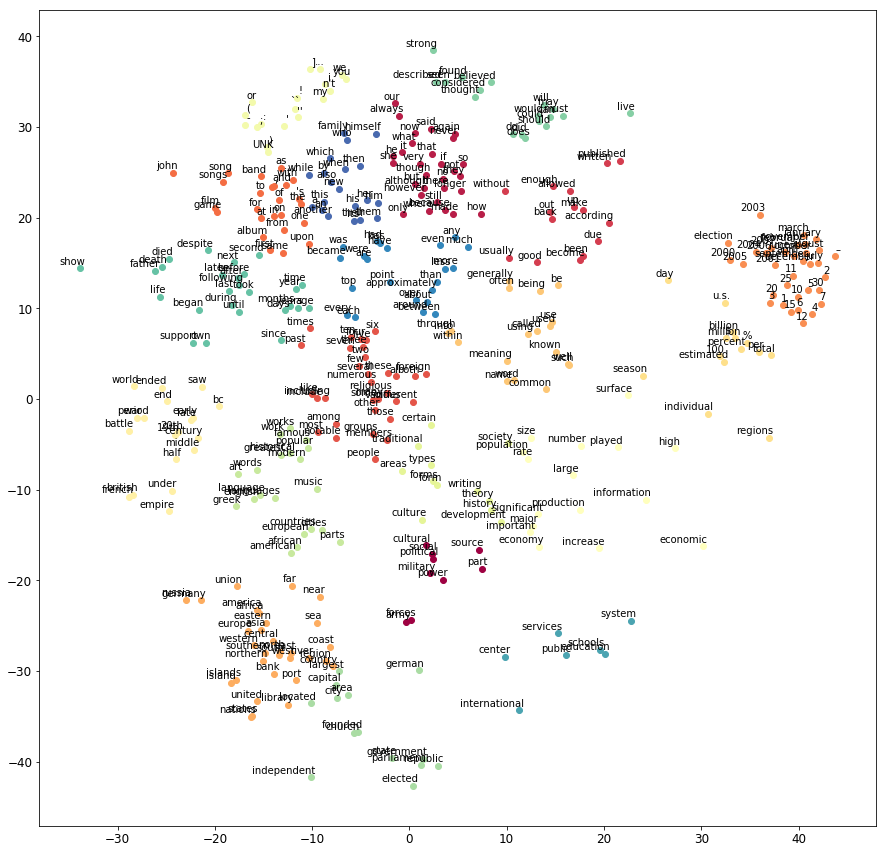

In [18]:

def plot(embeddings, labels):
  
  n_clusters = 20 # number of clusters
  # automatically build a discrete set of colors, each for cluster
  cmap = cm.get_cmap("Spectral") 
  #label_colors = [pylab.cm.spectral(float(i) /n_clusters) for i in range(n_clusters)]
  label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]
  
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  # Define K-Means
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
  kmeans_labels = kmeans.labels_
  
  pylab.figure(figsize=(15,15))  # in inches
    
  # plot all the embeddings and their corresponding words
  for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=label_colors[klabel])    
        
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=10)

  # use for saving the figure if needed
  #pylab.savefig('word_embeddings.png')
  pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)

In [20]:
# In[30]:
'''改find_clustered_embeddings的sample_threshold=1)
   再執行上面
   words = [reverse_dictionary[i] for i in selected_ids]
   plot(two_d_embeddings, wordscell '''
num_points = 1000 # we will use a large sample space to build the T-SNE 
                  # manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than 
# n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,1)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')


Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  985  samples were selected by pruning


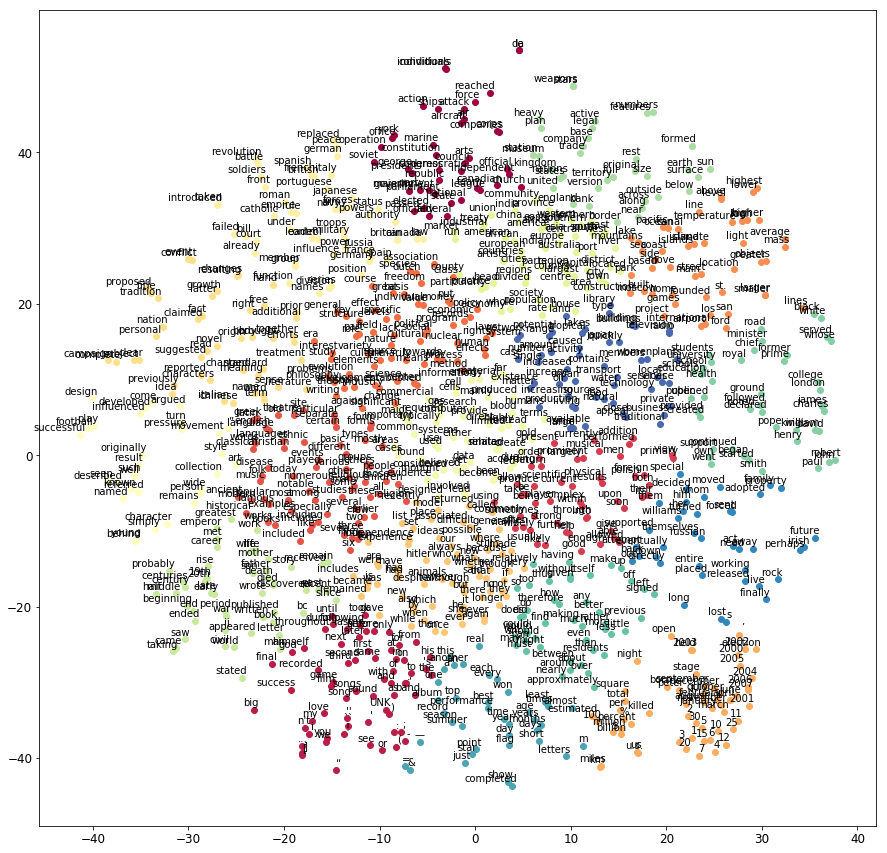

In [22]:
words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)

# CBOW Algorithm

## Changing the data generation process
We need to define a new data generator for CBOW. Shape of the new input array is (batch_size, context_window*2). That is, a batch in CBOW captures all the words in the context of a given word.

In [24]:
'''
目的：處理window_size範圍前後背景詞的span框架
傳入：text_digt, batch_size， window_size
傳回： batch為背景詞的list；
      label為背景詞框架內的中心詞list

例：text_digt: ['propaganda','is','a','concerted', 'set','of','messages','aimed']
 window_size=1 時回傳：
  batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
  labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']
  表span框架為 ([前1背景詞,後1背景詞]，中心詞):
      (['propaganda', 'a'],'is'), (['is', 'concerted'], 'a')...
      
 window_size=2 時回傳：   
  batch: [['propaganda','is','concerted','set'], ['is','a','set','of'],...]
  labels: ['a','concerted','set', 'of','messages','aimed','at','influencing']
  表span框架為 ([前2背景詞,前1背景詞,後1背景詞,後2背景詞]，中心詞):
      (['propaganda','is','concerted','set'], 'a'),
      (['is','a','set','of'], 'concerted')...       
'''
data_index = 0

def generate_batch_cbow(text_digt, batch_size, window_size):
    # window_size is the amount of words we're looking at from each side of a given word
    # creates a single batch
    
    # data_index is updated by 1 everytime we read a set of data point
    global data_index

    # span defines the total window size, where text_digt
    #  is we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    # e.g if skip_window = 2 then span = 5
    span = 2 * window_size + 1 # [ skip_window target skip_window ]

    # two numpy arras to hold target words (batch)
    # and context words (labels)
    # Note that batch has span-1=2*window_size columns
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(text_digt[data_index])
        data_index = (data_index + 1) % len(text_digt)

    # Here we do the batch reading
    # We iterate through each batch index
    # For each batch index, we iterate through span elements
    # to fill in the columns of batch array
    for i in range(batch_size):
        target = window_size  # target label at the center of the buffer
        target_to_avoid = [ window_size ] # we only need to know the words around a given word, not the word itself

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            # ignore the target word when creating the batch
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j] 
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Everytime we read a data point,
        # we need to move the span by 1
        # to create a fresh new span
        buffer.append(text_digt[data_index])
        data_index = (data_index + 1) % len(text_digt)

    return batch, labels

print('\ntext_digt:', [reverse_dictionary[di] for di in text_digt[:8]])

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(text_digt,\
                    batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])



text_digt: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

with window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [25]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
# How many words to consider left and right.
# Skip gram by design does not require to have all 
# the context words in a given step.
# However, for CBOW that's a requirement, so we limit the window size
window_size = 2 

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window 
# without always being deterministic.
valid_window = 50

# When selecting valid examples, we select some of the most
# frequent words as well as some moderately rare words as well.
valid_examples = np.array(random.sample(range(valid_window),\
                                        valid_size))
valid_examples = np.append(valid_examples,random.sample(\
                 range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.


### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [26]:
# In[36]:
reset_graph()

# Training input data (target word IDs).
# Note that it has 2*window_size columns
''' CBOW與skip_gram的train_dataset shape不同，
    因為CBOW的batch是2D, skip_gram的batch是1D'''
train_dataset = tf.placeholder(tf.int32,\
       shape=[batch_size, 2*window_size]) 
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)


### Defining Model Parameters and Other Variables
We now define several TensorFlow variables such as an embedding layer (`embeddings`) and neural network parameters (`softmax_weights` and `softmax_biases`)

In [27]:
# In[38]:
# Variables.

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform(\
  [vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights and Biases
softmax_weights = tf.Variable(\
      tf.truncated_normal([vocabulary_size, embedding_size],\
      stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases =  tf.Variable(\
      tf.random_uniform([vocabulary_size],0.0,0.01))


### Defining the Model Computations

We first defing a lookup function to fetch the corresponding embedding vectors for a set of given inputs. Concretely, we define 2$\times$`window_size` embedding lookups. We then concatenate all these looked up embedding vectors to form a matrix of size `[batch_size, embedding_size, 2*window_size]`. Thereafter, we average these embedding lookups to produce an average embeddings of size `[batch_size, embedding_size]`. With that, we define negative sampling loss function `tf.nn.sampled_softmax_loss` which takes in the embedding vectors and previously defined neural network parameters.

                       exp[Uc'(Vo1+Vo2+...Vo2m)/(2*m)]
P(Wc|Wo1,..., Wo2m) = _________________________________
                       ∑exp[Ui'(Vo1+Vo2+...Vo2m)/(2*m)]
 

In [34]:
# Model.
# Look up embeddings for a batch of inputs.
# Here we do embedding lookups for each column in the input placeholder
# and then average them to produce an embedding_size word vector
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'\
      %(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    print('embedding_i:', embedding_i)
    print('x_size:',x_size,'y_size:',y_size)
    if stacked_embedings is None:
        # 此stacked_embedings shape (128, 128, 1)
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
        stacked_embedings_1 = stacked_embedings
    else:
        # 此stacked_embedings shape (128, 128, 4)
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,\
                            tf.reshape(embedding_i,[x_size,y_size,1])])
        stacked_embedings_2 = stacked_embedings
assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
# mean_embeddings shape (128, 128)
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings
# num_sampled負採樣數
loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(\
  weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,\
  labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))


Defining 4 embedding lookups representing each word in the context
embedding_i: Tensor("embedding_lookup_9:0", shape=(128, 128), dtype=float32)
x_size: 128 y_size: 128
embedding_i: Tensor("embedding_lookup_10:0", shape=(128, 128), dtype=float32)
x_size: 128 y_size: 128
embedding_i: Tensor("embedding_lookup_11:0", shape=(128, 128), dtype=float32)
x_size: 128 y_size: 128
embedding_i: Tensor("embedding_lookup_12:0", shape=(128, 128), dtype=float32)
x_size: 128 y_size: 128
Stacked embedding size: [128, 128, 4]
Reduced mean embedding size: [128, 128]


### Model Parameter Optimizer

We then define a learning rate as a constant and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [29]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)


### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [30]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


## Running the CBOW Algorithm

In [35]:
num_steps = 100001
cbow_losses = []

# ConfigProto is a way of providing various configuration settings 
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_cbow(\
                       text_digt,batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        stem_1,stem_2,men_em,opt,l = session.run([stacked_embedings_1,\
                                stacked_embedings_2, mean_embeddings,\
                                optimizer, loss], feed_dict=feed_dict)
        #print('men_em shape',men_em.shape)    
        #print('stem_1',stem_1)
        #print('stem_2',stem_2)
        #print('men_em',men_em)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            cbow_losses.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
            
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = "Nearest to '%s' :" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()
    

np.save('cbow_embeddings', cbow_final_embeddings)

with open('cbow_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_losses)

Initialized
Average loss at step 2000: 3.576314
Average loss at step 4000: 3.067204
Average loss at step 6000: 2.947504
Average loss at step 8000: 2.871803
Average loss at step 10000: 2.807949
Nearest to 'to' : will, =-8, locomotion, slusser, worthington, relax, opposition-tabled, salts,
Nearest to 'in' : friedmann, examiner, picturesque, energies, until, install, balkan, szilárd,
Nearest to 'be' : have, mt, anthropology, marnie, is, shalt, summarise, sent,
Nearest to 'of' : donatello, keenan, worded, petticoat, ppd, fnla, rc, punishment,
Nearest to 'with' : harmful, carr, phenotype, studying, rubens, bovespa, zp-12, tdk,
Nearest to 'their' : its, his, the, a, fashoda, corrupted, these, horses,
Nearest to 'had' : has, have, 25.5, vlachs, was, 11,000, underhand, could,
Nearest to 'were' : are, was, fenians, juniors, berners-lee, 140,000, 19-year-old, have,
Nearest to 'other' : balances, these, k8, akademy, gassendi, omaha, paw, divinely,
Nearest to 'his' : their, its, her, parte, excita

Average loss at step 62000: 2.253225
Average loss at step 64000: 2.206847
Average loss at step 66000: 2.234757
Average loss at step 68000: 2.204099
Average loss at step 70000: 2.210731
Nearest to 'to' : will, toward, must, =-8, may, would, salts, okhotsk,
Nearest to 'in' : until, since, throughout, friedmann, during, picturesque, balkan, clot,
Nearest to 'be' : being, been, summarise, anthropology, 'uqba, was, mt, jury,
Nearest to 'of' : donatello, fnla, f6e, throbbing, concerning, war-weary, coping, ppd,
Nearest to 'with' : scout, harmful, tdk, studying, kraus, carr, blattberg, stove,
Nearest to 'their' : its, his, her, my, our, bitter, the, 37.,
Nearest to 'had' : has, have, having, attempted, 25.5, delirque, were, krong,
Nearest to 'were' : are, was, fenians, had, 140,000, northumbria, been, scoticanus,
Nearest to 'other' : various, these, individual, omaha, balances, akademy, inherits, others,
Nearest to 'his' : her, their, its, my, parte, our, quotation, realities,
Nearest to 'he'

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
Out of  1000  samples,  599  samples were selected by pruning


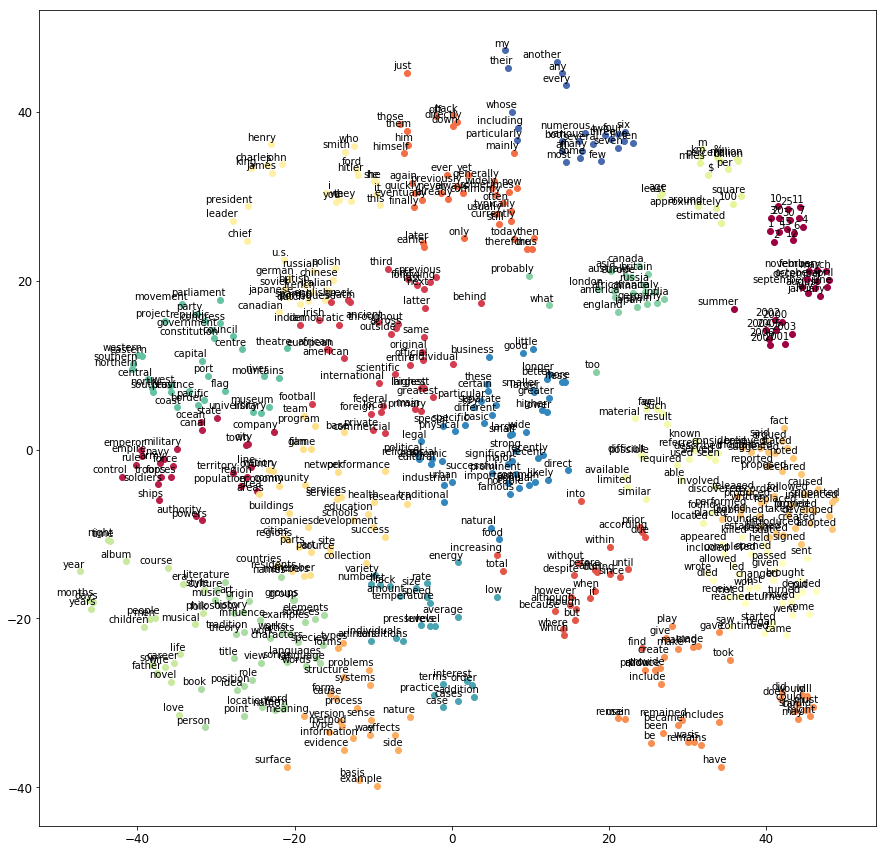

In [36]:
num_points = 1000 # we will use a large sample space to build the T-SNE 
                  # manifold and then prune it using cosine similarity

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold
selected_embeddings = cbow_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than 
# n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('Out of ',num_points,' samples, ', selected_ids.shape[0],' samples were selected by pruning')
words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)
